In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt


In [2]:
# Load data for Hosp_A
df = pd.read_csv('../data/inventory_Hosp_A.csv')
df.head()


,date,hospital_id,drug_name,inventory,demand
0,2024-01-01,Hosp_A,Paracetamol,152,61
1,2024-01-01,Hosp_A,Ibuprofen,142,24
2,2024-01-01,Hosp_A,Amoxicillin,156,81
3,2024-01-01,Hosp_A,Metformin,70,92
4,2024-01-01,Hosp_A,Atorvastatin,124,84


In [3]:
# Extract day of week from date
df['date'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['date'].dt.dayofweek  # Monday=0, Sunday=6

# Encode categorical features
le_drug = LabelEncoder()
df['drug_encoded'] = le_drug.fit_transform(df['drug_name'])

# Drop unused columns
df = df.drop(columns=['date', 'hospital_id', 'drug_name'])

# Show processed dataframe
df.head()


,inventory,demand,day_of_week,drug_encoded
0,152,61,0,4
1,142,24,0,2
2,156,81,0,0
3,70,92,0,3
4,124,84,0,1


In [4]:
X = df.drop(columns=['demand']).values
y = df['demand'].values

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to torch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)


In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
class DrugDemandDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = DrugDemandDataset(X_train, y_train)
val_dataset = DrugDemandDataset(X_val, y_val)

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [10]:
class DrugDemandMLP(nn.Module):
    def __init__(self, input_dim):
        super(DrugDemandMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # Output: predicted demand
        )
    
    def forward(self, x):
        return self.model(x)

# Instantiate model
input_dim = X_train.shape[1]
model = DrugDemandMLP(input_dim)


In [11]:
# Mean Squared Error for regression
criterion = nn.MSELoss()

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [12]:
# Lists to store loss values
train_losses = []
val_losses = []

# Number of epochs
epochs = 30

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs} — Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch 1/30 — Train Loss: 3527.5467, Val Loss: 3618.6610
Epoch 2/30 — Train Loss: 3508.8401, Val Loss: 3597.3077
Epoch 3/30 — Train Loss: 3485.3813, Val Loss: 3573.3080
Epoch 4/30 — Train Loss: 3455.5755, Val Loss: 3543.6616
Epoch 5/30 — Train Loss: 3439.3961, Val Loss: 3506.5806
Epoch 6/30 — Train Loss: 3322.2784, Val Loss: 3461.3645
Epoch 7/30 — Train Loss: 3306.7373, Val Loss: 3407.4895
Epoch 8/30 — Train Loss: 3265.7925, Val Loss: 3342.8838
Epoch 9/30 — Train Loss: 3287.7676, Val Loss: 3265.7354
Epoch 10/30 — Train Loss: 3144.7310, Val Loss: 3175.8722
Epoch 11/30 — Train Loss: 3096.3834, Val Loss: 3072.9919
Epoch 12/30 — Train Loss: 2959.8766, Val Loss: 2954.2474
Epoch 13/30 — Train Loss: 2905.6049, Val Loss: 2822.5131
Epoch 14/30 — Train Loss: 2687.5761, Val Loss: 2676.0282
Epoch 15/30 — Train Loss: 2524.1771, Val Loss: 2519.0654
Epoch 16/30 — Train Loss: 2353.3117, Val Loss: 2351.4404
Epoch 17/30 — Train Loss: 2163.4462, Val Loss: 2177.7685
Epoch 18/30 — Train Loss: 2029.9373, Val

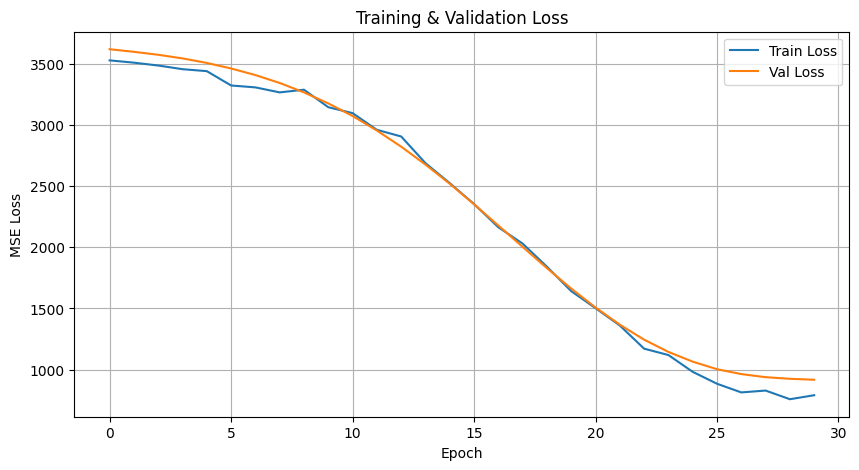

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()
